In [1]:
import os.path

import accelerator_environments
import gym
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise

In [2]:
env = gym.make("ARESEA-JOSS-v0")

initializing ocelot...
/usr/local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
env

<TimeLimit<ARESEAJOSS<ARESEA-JOSS-v0>>>

In [4]:
env = accelerator_environments.wrappers.NormalizeAction(env)
env = accelerator_environments.wrappers.NormalizeObservation(env)
env = accelerator_environments.wrappers.NormalizeReward(env)
env

<NormalizeReward<NormalizeObservation<NormalizeAction<TimeLimit<ARESEAJOSS<ARESEA-JOSS-v0>>>>>>

In [5]:
n_actions = env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = DDPG("MlpPolicy", env, action_noise=action_noise, buffer_size=20000, verbose=2)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [6]:
filename = "model_normalization_3"
if os.path.exists(filename + ".zip"):
    model.load(filename)
else:
    model.learn(total_timesteps=10000)
    model.save(filename)

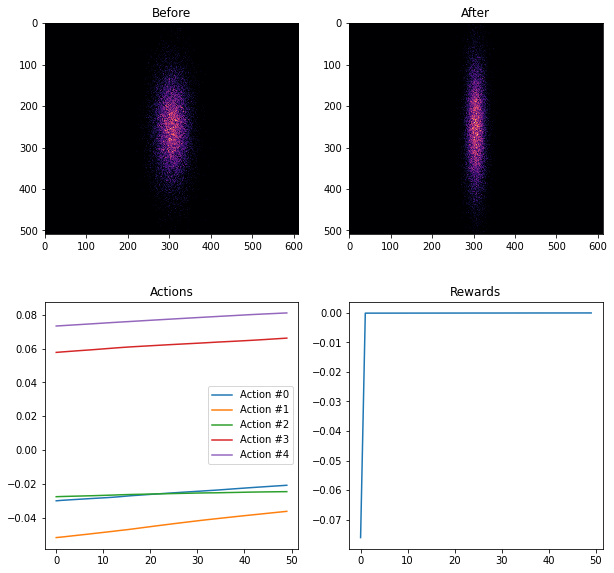

In [7]:
env_monitor = gym.wrappers.Monitor(env, "recordings", video_callable=lambda _: True, force=True)
observation = env_monitor.reset()
before = env_monitor.render()
i = 0
actions = np.zeros((50, n_actions))
rewards = np.zeros(50)
done = False
while not done:
    action, _state = model.predict(observation, deterministic=True)
    actions[i] = action
    observation, reward, done, info = env_monitor.step(action)
    rewards[i] = reward
    i += 1
after = env_monitor.render()
env_monitor.reset()

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title("Before")
plt.imshow(before, interpolation="None")
plt.subplot(222)
plt.title("After")
plt.imshow(after, interpolation="None")
plt.subplot(223)
plt.title("Actions")
for i in range(n_actions): plt.plot(actions[:,i], label=f"Action #{i}")
plt.legend()
plt.subplot(224)
plt.title("Rewards")
plt.plot(rewards)
plt.show()